In [89]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import aa598.hw1_helper as hw1_helper


from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True) # set to False if latex is not set up on your computer

## Visualize data

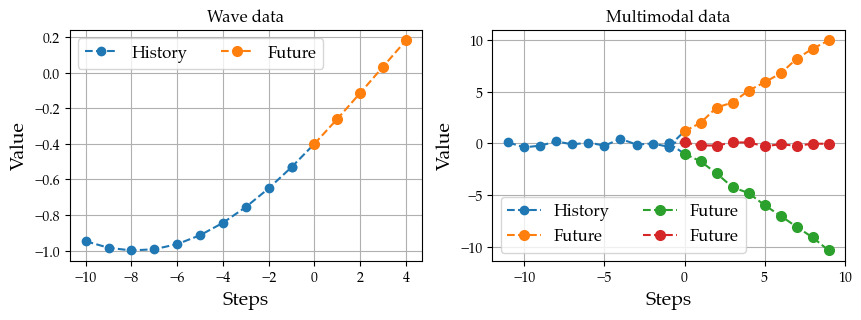

In [90]:
with open("data/hw1/wave_data_train.pickle", 'rb') as handle:
    wave_data = pickle.load(handle)
history = wave_data["history"]
future = wave_data["future"]

index = 3
history_length = history.shape[-1]
future_length = future.shape[-1]
ts_history = np.arange(-history_length,0)
ts_future = np.arange(future_length)

plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.plot(ts_history, history[index], marker='o', linestyle='--', label="History")
plt.plot([-1,0], [history[index][-1], future[index][0]], marker='o', linestyle='--', color="C0")
plt.plot(ts_future, future[index], markersize=7, marker='o', linestyle='--', label="Future")

plt.xlabel('Steps', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12, ncols=2)
plt.title("Wave data")
plt.grid(True)
# plt.show()



with open("data/hw1/multimodal_data_test.pickle", 'rb') as handle:
    wave_data = pickle.load(handle)
history = wave_data["history"]
future = wave_data["future"]


index = 1
history_length = history.shape[-1]
future_length = future.shape[-1]
ts_history = np.arange(-history_length,0)
ts_future = np.arange(future_length)

plt.subplot(1,2,2)
plt.plot(ts_history, history[index], marker='o', linestyle='--', label="History")
for i in range(3):
    plt.plot([-1,0], [history[i*100 + index][-1], future[i*100 + index][0]], marker='o', linestyle='--', color="C0")
    plt.plot(ts_future, future[i*100 + index], markersize=7, marker='o', linestyle='--', label="Future")

plt.xlabel('Steps', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12, ncols=2)
plt.title("Multimodal data")
plt.grid(True)
plt.show()


## Regression with sinusoidal trajectories

In this problem, you will learn a regular MLP to regress on sinusoidal data

In [16]:
# feel free to poke around the data
train_data = hw1_helper.TrajectoryData("data/hw1/wave_data_train")
test_data = hw1_helper.TrajectoryData("data/hw1/wave_data_test")

history_length = 10
future_length = 5
input_size = 1
output_size = 1

print("Train set has %i examples"%len(train_data))
print("Test set has %i examples"%len(test_data))

Train set has 10000 examples
Test set has 500 examples


### Simple MLP predictor

In [128]:
# Define a simple MLP model
class MLP(torch.nn.Module):
    def __init__(self, history_length, future_length, hidden_size=32):
        super(MLP, self).__init__()
        
        # TODO: construct MLP network
        self.model = torch.nn.Sequential(
            torch.nn.Linear(history_length, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 3),
            torch.nn.ReLU(),
            torch.nn.Linear(3, future_length),
        )
        #############################

    def forward(self, x):
        return self.model(x)



In [129]:
hidden_size = 8
history_length = 10
future_length = 5

model = MLP(history_length, future_length, hidden_size)

learning_rate = 0.001
num_epochs = 30
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [130]:
model, optimizer = hw1_helper.train(model, optimizer, train_dataloader, criterion, num_epochs)


Epoch [1/30], Step [0/313], Loss: 0.7387
Epoch [1/30], Step [20/313], Loss: 0.5853
Epoch [1/30], Step [40/313], Loss: 0.7175
Epoch [1/30], Step [60/313], Loss: 0.5745
Epoch [1/30], Step [80/313], Loss: 0.5580
Epoch [1/30], Step [100/313], Loss: 0.4198
Epoch [1/30], Step [120/313], Loss: 0.3996
Epoch [1/30], Step [140/313], Loss: 0.4479
Epoch [1/30], Step [160/313], Loss: 0.4559
Epoch [1/30], Step [180/313], Loss: 0.3618
Epoch [1/30], Step [200/313], Loss: 0.3593
Epoch [1/30], Step [220/313], Loss: 0.3177
Epoch [1/30], Step [240/313], Loss: 0.3468
Epoch [1/30], Step [260/313], Loss: 0.3378
Epoch [1/30], Step [280/313], Loss: 0.2307
Epoch [1/30], Step [300/313], Loss: 0.2306
Epoch 1 completed with average loss: 0.4117
Epoch [2/30], Step [0/313], Loss: 0.2359
Epoch [2/30], Step [20/313], Loss: 0.1562
Epoch [2/30], Step [40/313], Loss: 0.1763
Epoch [2/30], Step [60/313], Loss: 0.1029
Epoch [2/30], Step [80/313], Loss: 0.0902
Epoch [2/30], Step [100/313], Loss: 0.1856
Epoch [2/30], Step [12

In [131]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history)         # Forward pass
    loss = criterion(prediction, future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# Visualize prediction on test data
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_data)-1, step=1, description='Index:')
xlims = [-11, 5]
ylims = [-2,2]
interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



Test Loss: 0.0014


interactive(children=(IntSlider(value=0, description='Index:', max=499), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

### Simple LSTM predictor

In [151]:
    
class LSTM(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        # HINT: Use Pytorch built-in functions for LSTM and Linear layers.
        # HINT: batch dimension is dim=0

        '''
        looking at the code provided on pytorch

        
        nn.LSTM is looking for an input and an output without specifying that it is
        being used as an encoder or a decoder so it can be reversed?

        nn.Linear is a transformation that turn the output into a linearized equation where y = Ax + b
            b is the bias
            A is the weight
            y is the output
        '''
        
        # TODO: Define encoder LSTM.
        self.encoder = torch.nn.LSTM(input_dim, hidden_dim, batch_first=True)
        ############################
        
        
        # TODO: Define decoder LSTM
        self.decoder = torch.nn.LSTM(input_dim, hidden_dim, batch_first=True)
        ############################
        
        
        #TODO: Define linear project from hidden_dim to output_dim
        # The output is a scalar but it needs to be an array [~,4]
        self.projection = torch.nn.Linear(hidden_dim, output_dim, bias = False)
        ############################
        

    def forward(self, x, t_max, y=None, prob=1.):
        """
        Forward pass of the LSTM model.
        x: The input sequence [batch_size, seq_len, input_dim]
        t_max: maximum time steps to unroll
        y: The target sequence for teacher forcing (optional, used if teacher forcing is applied) [batch_size, t_max, output_dim]
        prob: Probability to apply teacher forcing (0 to 1). 1 means 100% teacher forcing, 
        """
        
        # making sure x and y is the appropriate size.
        if len(x.shape) == 2:
            x = x.unsqueeze(-1)
        if y is not None and len(y.shape) == 2:
            y = y.unsqueeze(-1)
        
        
        ys = [] # collect outputs
        # TODO: Run input through encoder to get initial hidden state for decoder
        _, h = self.encoder(x)
        ############################
        
        
        # TODO: initial state for decoder is last input state
        y_input = x[:,-1, :]
        y_input = y_input.unsqueeze(1)
        ############################
        

        # TODO: unroll decoder 
        # TODO: if eval or no teacher forcing, use prediction from previous step
        # TODO: if train and using teacher forcing, use prob to determine whether to use ground truth or previous prediction
        
        ############################
        for i in range(t_max):
            output, h = self.decoder(y_input, h)
            output = self.projection(output)
            # TODO: y_input = ...?
            random = torch.rand([2, 4])
            # if sum(random[0, :] >= 2):
            #     y_input = output
            # else:
            #     y_input = x[:,-1, :]
            y_input = output
            ys.append(output.squeeze(1))
        ys = torch.cat(ys, dim=1)
    
        
        return ys # [batch_size, ts_max, output_dim]

In [152]:
hidden_size = 4
future_length = 5
input_size = 1
output_size = 1

model = LSTM(input_size, output_size, hidden_size)

learning_rate = 0.001
num_epochs = 10
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
prob = 0.

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()


def prob_schedule(i):
    return 1 - jax.nn.sigmoid(20 * (i - 0.5)).item()



In [153]:
# we use a slightly different training loop to account for teacher forcing
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    prob = prob_schedule((epoch + 1)/num_epochs)
    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()        # Zero the gradients
        output = model(data, future_length, target, prob)         # Forward pass
        loss = criterion(output, target)  # Compute loss
        loss.backward()              # Backpropagation
        optimizer.step()             # Update weights

        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f}')

print("Training finished!")


Epoch [1/10], Step [0/313], Loss: 0.6056
Epoch [1/10], Step [100/313], Loss: 0.4863
Epoch [1/10], Step [200/313], Loss: 0.2902
Epoch [1/10], Step [300/313], Loss: 0.1305
Epoch 1 completed with average loss: 0.3637
Epoch [2/10], Step [0/313], Loss: 0.0726
Epoch [2/10], Step [100/313], Loss: 0.0670
Epoch [2/10], Step [200/313], Loss: 0.0696
Epoch [2/10], Step [300/313], Loss: 0.0526
Epoch 2 completed with average loss: 0.0599
Epoch [3/10], Step [0/313], Loss: 0.0383
Epoch [3/10], Step [100/313], Loss: 0.0371
Epoch [3/10], Step [200/313], Loss: 0.0250
Epoch [3/10], Step [300/313], Loss: 0.0279
Epoch 3 completed with average loss: 0.0302
Epoch [4/10], Step [0/313], Loss: 0.0227
Epoch [4/10], Step [100/313], Loss: 0.0260
Epoch [4/10], Step [200/313], Loss: 0.0204
Epoch [4/10], Step [300/313], Loss: 0.0171
Epoch 4 completed with average loss: 0.0196
Epoch [5/10], Step [0/313], Loss: 0.0194
Epoch [5/10], Step [100/313], Loss: 0.0183
Epoch [5/10], Step [200/313], Loss: 0.0115
Epoch [5/10], Ste

In [154]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history, future_length)         # Forward pass
    loss = criterion(prediction, future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# try with different prediction horizons
prediction_horizon = 20
prediction = model(history, prediction_horizon)


# Visualize prediction on test data
test_dataloader = list(DataLoader(test_data, batch_size=1, shuffle=False))
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_dataloader)-1, step=1, description='Index:')
xlims = [-11, prediction_horizon + 2]
ylims = [-5,5]
interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



Test Loss: 0.0095


interactive(children=(IntSlider(value=0, description='Index:', max=499), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

## Regression on multimodal data

Now we repeat the same steps but with data where the future has multimodal outcome. 

In [155]:
# load multimodal data
train_data = hw1_helper.TrajectoryData("data/hw1/multimodal_data_train")
test_data = hw1_helper.TrajectoryData("data/hw1/multimodal_data_test")

history_length = 11
future_length = 10
input_size = 1
output_size = 1

print("Train set has %i examples"%len(train_data))
print("Test set has %i examples"%len(test_data))

Train set has 15000 examples
Test set has 300 examples


### Simple MLP predictor (multimodal data)

In [156]:

hidden_size = 32
# You should be able to use your MLP class
model = MLP(history_length, future_length, hidden_size)

learning_rate = 0.001
num_epochs = 10
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

In [157]:
model, optimizer = hw1_helper.train(model, optimizer, train_dataloader, criterion, num_epochs)

Epoch [1/10], Step [0/469], Loss: 27.8842
Epoch [1/10], Step [20/469], Loss: 24.3046
Epoch [1/10], Step [40/469], Loss: 26.7002
Epoch [1/10], Step [60/469], Loss: 20.4398
Epoch [1/10], Step [80/469], Loss: 26.5939
Epoch [1/10], Step [100/469], Loss: 25.3053
Epoch [1/10], Step [120/469], Loss: 26.7354
Epoch [1/10], Step [140/469], Loss: 25.6718
Epoch [1/10], Step [160/469], Loss: 20.4935
Epoch [1/10], Step [180/469], Loss: 25.4171
Epoch [1/10], Step [200/469], Loss: 25.4394
Epoch [1/10], Step [220/469], Loss: 27.6147
Epoch [1/10], Step [240/469], Loss: 31.2583
Epoch [1/10], Step [260/469], Loss: 26.6167
Epoch [1/10], Step [280/469], Loss: 24.2969
Epoch [1/10], Step [300/469], Loss: 26.5391
Epoch [1/10], Step [320/469], Loss: 26.5961
Epoch [1/10], Step [340/469], Loss: 25.1573
Epoch [1/10], Step [360/469], Loss: 21.5549
Epoch [1/10], Step [380/469], Loss: 27.8386
Epoch [1/10], Step [400/469], Loss: 23.0557
Epoch [1/10], Step [420/469], Loss: 27.9061
Epoch [1/10], Step [440/469], Loss: 26

In [160]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history)         # Forward pass
    loss = criterion(prediction, future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# Visualize prediction on test data
test_dataloader = list(DataLoader(test_data, batch_size=1, shuffle=False))
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_dataloader)-1, step=1, description='Index:')
xlims = [-11, 10]
ylims = [-12, 12]
interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



Test Loss: 25.7155


interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

### Simple LSTM predictor (multimodal data)

In [161]:
hidden_size = 4
# You should be able to use your LSTM class
model = LSTM(input_size, output_size, hidden_size)

learning_rate = 0.001
num_epochs = 10
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()


In [162]:
# we use a slightly different training loop to account for teacher forcing
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()        # Zero the gradients
        output = model(data, future_length, target, prob)         # Forward pass
        loss = criterion(output, target)  # Compute loss
        loss.backward()              # Backpropagation
        optimizer.step()             # Update weights

        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f}')

print("Training finished!")


Epoch [1/10], Step [0/469], Loss: 27.7098
Epoch [1/10], Step [100/469], Loss: 29.9572
Epoch [1/10], Step [200/469], Loss: 23.0538
Epoch [1/10], Step [300/469], Loss: 31.2159
Epoch [1/10], Step [400/469], Loss: 15.7470
Epoch 1 completed with average loss: 25.7088
Epoch [2/10], Step [0/469], Loss: 26.5634
Epoch [2/10], Step [100/469], Loss: 23.9340
Epoch [2/10], Step [200/469], Loss: 30.1798
Epoch [2/10], Step [300/469], Loss: 24.2285
Epoch [2/10], Step [400/469], Loss: 24.1748
Epoch 2 completed with average loss: 25.7097
Epoch [3/10], Step [0/469], Loss: 29.0563
Epoch [3/10], Step [100/469], Loss: 24.1717
Epoch [3/10], Step [200/469], Loss: 20.3522
Epoch [3/10], Step [300/469], Loss: 27.5934
Epoch [3/10], Step [400/469], Loss: 25.1517
Epoch 3 completed with average loss: 25.7104
Epoch [4/10], Step [0/469], Loss: 26.5651
Epoch [4/10], Step [100/469], Loss: 27.7761
Epoch [4/10], Step [200/469], Loss: 30.2113
Epoch [4/10], Step [300/469], Loss: 25.0586
Epoch [4/10], Step [400/469], Loss: 2

In [163]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history, future_length)         # Forward pass
    loss = criterion(prediction, future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# TODO: try with different prediction horizons
prediction_horizon = future_length
prediction = model(history, prediction_horizon)


# Visualize prediction on test data
test_dataloader = list(DataLoader(test_data, batch_size=1, shuffle=False))
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_dataloader)-1, step=1, description='Index:')

xlims = [-11, prediction_horizon + 2]
ylims = [-12, 12]

interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



Test Loss: 25.7152


interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

## Consider CVAEs

First, define the encoder and decoder. We will consider some simple MLP encoders. Generally, for trajectory data, it's typically more common to use RNNs or transformers, but since we are considering a small toy problem, we just consider MLP for now since it's simpler.


In [1089]:

# some simple MLP encoders. For trajectory data, it's typically more common to use RNNs or transformers
class MLPEncoder(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=32):
        super(MLPEncoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # TODO: Construct an MLP encoder
        # self.model = None   
        self.model = torch.nn.Sequential(
                torch.nn.Linear(input_dim, 12),
                torch.nn.Tanh(),
                torch.nn.Linear(12, 10),
                torch.nn.Tanh(),
                torch.nn.Linear(10, output_dim),
                )
        ############################


    def forward(self, x):
        return self.model(x)
    
    
class MLPDecoder(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=32):
        super(MLPDecoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # TODO: Construct an MLP encoder
        # self.model = None
        self.model = torch.nn.Sequential(
                torch.nn.Linear(input_dim, 12),
                torch.nn.Tanh(),
                torch.nn.Linear(12, 10),
                torch.nn.Linear(10, output_dim),
                )
        ############################


    def forward(self, x):
        return self.model(x)


# Some helper functions
def repeat_n(ten, n):
    return torch.stack([ten] * n, dim=0)

def beta_schedule(i):
    return jax.nn.sigmoid(20 * (i - 0.5)).item()


In [1090]:
train_data = hw1_helper.TrajectoryData("data/hw1/multimodal_data_train")
test_data = hw1_helper.TrajectoryData("data/hw1/multimodal_data_test")

history_length = 11
future_length = 10
input_size = 1
output_size = 1

print("Train set has %i examples"%len(train_data))
print("Test set has %i examples"%len(test_data))

Train set has 15000 examples
Test set has 300 examples


### Continuous CVAE

In [1091]:
class ContinuousCVAE(torch.nn.Module):
    def __init__(self, latent_dim, importance, decoder, prior):
        '''
        latent_dim: dimension of the continuous latent space
        importance: network to encode the importance weight
        decoder: network to decode the output
        prior: network to encode the prior        
        '''
        
        super(ContinuousCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.importance = importance
        self.decoder = decoder
        self.prior = prior
        
        # TODO: Linear layers to project encoder/decoder to mean and logvar
        self.mean_projection_encoder = torch.nn.Linear(importance.output_dim, latent_dim)
        self.logvar_projection_encoder = torch.nn.Linear(importance.output_dim, latent_dim)
        self.mean_projection_decoder = torch.nn.Linear(decoder.output_dim, decoder.output_dim)
        self.logvar_projection_decoder = torch.nn.Linear(decoder.output_dim, decoder.output_dim)
        
        ############################

        
    def encode_importance(self, x, y):
        '''Computes mean and log(covariance) of q(z|x,y), assumes normal distribution'''
        
        # TODO: compute z_mu and z_logvar of q(z|x,y)
        xy = torch.cat([x,y], dim=-1)
        h = self.importance(xy)
        z_mu = self.mean_projection_encoder(h)
        z_logvar = self.logvar_projection_encoder(h)

        ############################
        
        return z_mu, z_logvar
    
    
    def encode_prior(self, x):
        '''Computes mean and log(covariance) of p(z|x), assumes normal distribution'''
        
        # TODO: compute z_mu and z_logvar of p(z|x)
        k = self.prior(x)
        z_mu = self.mean_projection_encoder(k)
        z_logvar = self.logvar_projection_encoder(k)
        
        ############################
        
        return z_mu, z_logvar
    
    
    def reparameterize(self, mu, logvar, n=1):
        '''samples from a normal distributions parameterized by mu and logvar. Uses PyTorch built-in reparameratization trick'''
        
        prob = torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=torch.diag_embed(torch.exp(logvar)))
        
        return prob.rsample((n,))
    
    
    def decode(self, x, z):
        '''Computes mean and log(covariance) of p(y|x,z), assumes normal distribution'''
        
        # TODO: compute y_mu and y_logvar of p(y|x,z)
        xz = torch.cat([x, z], dim=-1)
        g = self.decoder(xz)
        y_mu = self.mean_projection_decoder(g)
        y_logvar = self.logvar_projection_decoder(g)
        
        ############################
        
        
        return y_mu, y_logvar

    
    def forward(self, x, y, n=1):
        '''forward pass of the cvae model'''
        
        #  get p(z|x,(y))
        if self.training:
            z_mu, z_logvar = self.encode_importance(x, y)
        else:
            z_mu, z_logvar = self.encode_prior(x)
        # sample from p(z|x,(y)) n times
        z = self.reparameterize(z_mu, z_logvar, n)
        # get p(y|x,z)
        y_mu, y_logvar  = self.decode(repeat_n(x, n), z)     
           
        return z_mu, z_logvar, y_mu, y_logvar
    

    
    def sample(self, x, num_samples=8, num_latent_samples=8):
        '''samples from p(y|x,z) where z~p(z|x). Need to specify the number z and y samples to draw'''
        
        _, _, y_mu, y_logvar = self.forward(x, None, num_latent_samples)

        return self.reparameterize(y_mu, y_logvar, num_samples)

    
    
    def elbo(self, x, y, z_samples=1, beta=1.):
        '''Compute ELBO for CVAE with continuous latent space. Optional: beta term that weigh kl divergence term'''
        
        q_mu, q_logvar, y_mu, y_logvar = self(x, y, z_samples) # get parameters for q(z|x,y) and p(y|x,z) where z~q(z|x,y)
        p_mu, p_logvar = self.encode_prior(x) # get parameters for p(z|x)
        
        # construct the distributions
        y_prob = torch.distributions.MultivariateNormal(loc=y_mu, covariance_matrix=torch.diag_embed(torch.exp(y_logvar)))  # p(y|x, z)
        q = torch.distributions.MultivariateNormal(loc=q_mu, covariance_matrix=torch.diag_embed(torch.exp(q_logvar)))  # q(z|x,y)
        p = torch.distributions.MultivariateNormal(loc=p_mu, covariance_matrix=torch.diag_embed(torch.exp(p_logvar)))  # p(z|x)
        
        loglikelihood = -y_prob.log_prob(repeat_n(y, z_samples)).mean() # log likelihood of data 
        kl_div = torch.distributions.kl.kl_divergence(q, p).mean()  # q_z * (log(q_z) - log(p_z))
        
        return loglikelihood + beta * kl_div
        


      

In [1092]:
# continuous cvae
# network parameters
latent_dim = 1 # size of latent space
history_length = 11
future_length = 10
hidden_dim = 8
enc_dim = 8
dec_dim = 8

encoder = MLPEncoder(history_length + future_length, hidden_dim, enc_dim)
prior = MLPEncoder(history_length, hidden_dim, enc_dim)
decoder = MLPDecoder(latent_dim+history_length, future_length, dec_dim)

cvae = ContinuousCVAE(latent_dim, encoder, decoder, prior)

num_epochs = 10
learning_rate = 1E-3
optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate)


batch_size = 8
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)



In [1093]:
# train model
z_samples = 16
cvae.train()

for epoch in range(num_epochs):
    running_loss = 0
    beta = beta_schedule((epoch + 1)/ num_epochs) # we slowly increase the weighting on the KL divergence, following https://openreview.net/forum?id=Sy2fzU9gl
    for batch_idx, (history, future) in enumerate(train_dataloader):
        q_mu, q_logvar, y_mu, y_logvar = cvae(history, future)
        p_mu, p_logvar = cvae.encode_prior(history)
        optimizer.zero_grad()
        loss = cvae.elbo(history, future, z_samples, beta)
        loss.backward()
        running_loss += loss.detach().cpu().numpy()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'======= Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f} =======')

print("Training finished!")

Epoch [1/10], Step [0/1875], Loss: 146.8116
Epoch [1/10], Step [100/1875], Loss: 40.9486
Epoch [1/10], Step [200/1875], Loss: 29.1800
Epoch [1/10], Step [300/1875], Loss: 24.2054
Epoch [1/10], Step [400/1875], Loss: 25.5176
Epoch [1/10], Step [500/1875], Loss: 22.3887
Epoch [1/10], Step [600/1875], Loss: 25.9292
Epoch [1/10], Step [700/1875], Loss: 11.0315
Epoch [1/10], Step [800/1875], Loss: 22.0225
Epoch [1/10], Step [900/1875], Loss: 29.6792
Epoch [1/10], Step [1000/1875], Loss: 17.8834
Epoch [1/10], Step [1100/1875], Loss: 17.6209
Epoch [1/10], Step [1200/1875], Loss: 21.6992
Epoch [1/10], Step [1300/1875], Loss: 13.7339
Epoch [1/10], Step [1400/1875], Loss: 21.8011
Epoch [1/10], Step [1500/1875], Loss: 21.1346
Epoch [1/10], Step [1600/1875], Loss: 13.8756
Epoch [1/10], Step [1700/1875], Loss: 21.5726
Epoch [1/10], Step [1800/1875], Loss: 21.3504
======= Epoch 1 completed with average loss: 24.6469 =======
Epoch [2/10], Step [0/1875], Loss: 17.9135
Epoch [2/10], Step [100/1875], Lo

In [1095]:
# Visualize prediction on test data

cvae.eval()

num_samples = 8
num_latent_samples = 8

test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = cvae.sample(history, num_samples, num_latent_samples)
    
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_data)-1, step=1, description='Index:')
xlims = [-12, 10]
ylims = [-12, 12]
interact(hw1_helper.plot_data_generative, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))


interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_generative(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

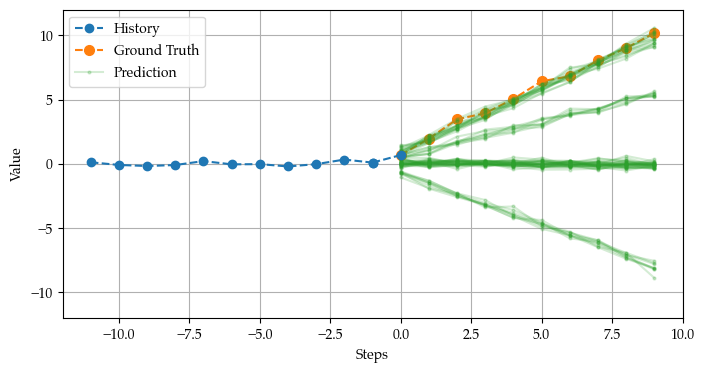

In [1096]:
index = 5 # choose an index you want to plot
hw1_helper.plot_data_generative(history=history, future=future, prediction=prediction, index=index, xlims=xlims, ylims=ylims)


### Discrete CVAE

In [1097]:
class DiscreteCVAE(torch.nn.Module):
    def __init__(self, latent_dim, importance, decoder, prior, num_categories):
        '''
        latent_dim: dimension of the continuous latent space
        importance: network to encode the importance weight
        decoder: network to decode the output
        prior: network to encode the prior  
        num_categories: number of categories per latent dimension 
        '''
        
        super(DiscreteCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.importance = importance
        self.decoder = decoder
        self.prior = prior
        
        self.logits_projection_encoder = torch.nn.Linear(importance.output_dim, latent_dim * num_categories)
        self.mean_projection_decoder = torch.nn.Linear(decoder.output_dim, decoder.output_dim)
        self.logvar_projection_decoder = torch.nn.Linear(decoder.output_dim, decoder.output_dim)
        self.num_categories = num_categories
        
        # Gumbel-softmax reparameterization
        self.gumbel_temperature = 0.1
        
    def encode_importance(self, x, y):
        '''Computes logits of q(z|x,y), assumes one-hot categorical'''
        xy = torch.cat([x, y], dim=-1)
        h = self.importance(xy)
        z_logits = self.logits_projection_encoder(h).reshape(-1, self.latent_dim, self.num_categories)      
        return z_logits
    
    
    def encode_prior(self, x):
        '''Computes logits of p(z|x), assumes one-hot categorical'''
        h = self.prior(x)
        z_logits = self.logits_projection_encoder(h).reshape(-1, self.latent_dim, self.num_categories)
        
        return z_logits


    def reparameterize(self, logits):
        '''Sample latent variables using one-hot categorical distributions. Uses gumbel-softmax trick. Pytorch has a bulit-in function for this.'''
        
        return F.gumbel_softmax(logits, tau=self.gumbel_temperature, hard=True) 
        
        
    def decode(self, x, z):
        '''Computes mean and log(covariance) of p(y|x,z), assumes normal distribution'''
        xz = torch.cat([x, z], dim=-1)
        g = self.decoder(xz)
        y_mu = self.mean_projection_decoder(g)
        y_logvar = torch.clip(self.logvar_projection_decoder(g), min=-10, max=1)
        
        return y_mu, y_logvar


    def forward(self, x, y, n=1):
        '''forward pass of the cvae model'''
        #  get p(z|x,(y)) and samples from it n times
        if self.training:
            logits = self.encode_importance(x, y) # [bs, latent_dim, num_categories]
            z = self.reparameterize(repeat_n(logits, n)) # [n, bs, latent_dim, num_categories]
        else:
            logits = self.encode_prior(x) # [bs, latent_dim, num_categories]
            z = torch.distributions.OneHotCategorical(logits=logits).sample((n,)) # [n, bs, latent_dim, num_categories]
        z_flatten = z.view(n, -1, self.latent_dim * self.num_categories)  # reshapes to [n, bs, latent_dim * num_categories]
        # get p(y|x,z)
        y_mu, y_logvar  = self.decode(repeat_n(x, n), z_flatten) 

        return logits, y_mu, y_logvar
    
    
    def sample(self, x, num_samples=8, num_latent_samples=8):
        '''samples from p(y|x,z) where z~p(z|x). Need to specify the number z and y samples to draw'''
        _, y_mu, y_logvar = self.forward(x, None, num_latent_samples)

        return  torch.distributions.MultivariateNormal(loc=y_mu, covariance_matrix=torch.diag_embed(torch.exp(y_logvar))).rsample((num_samples,))
        
        
    def elbo(self, x, y, z_samples=1, beta=1.):
        '''Compute ELBO for CVAE with discrete latent space. Optional: beta term that weigh kl divergence term'''

        logits, y_mu, y_logvar = self.forward(x, y, z_samples)
        prior_logits = cvae.encode_prior(x)
        
        y_prob = torch.distributions.MultivariateNormal(loc=y_mu, covariance_matrix=torch.diag_embed(torch.exp(y_logvar)))  # p(y|x, z)
        
        q_z = F.softmax(logits, dim=-1)  # q(z|x,y)
        log_p_z = F.log_softmax(prior_logits, dim=-1)  # log(p(z|x))
        
        loglikelihood = -y_prob.log_prob(repeat_n(y, z_samples)).mean()
        kl_div = torch.nn.KLDivLoss(reduction="batchmean")(log_p_z, q_z)
        
        return loglikelihood + beta * kl_div
      

        


In [1098]:
# discrete CVAE

history_length = 11
future_length = 10
hidden_dim = 8
enc_dim = 8
dec_dim = 8

latent_dim = 2
num_categories = 3

encoder = MLPEncoder(history_length + future_length, hidden_dim, enc_dim)
prior = MLPEncoder(history_length, hidden_dim, enc_dim)
decoder = MLPDecoder(latent_dim * num_categories + history_length, future_length, dec_dim)

cvae = DiscreteCVAE(latent_dim, encoder, decoder, prior, num_categories)

learning_rate = 1E-3
optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate, weight_decay=1E-2)

batch_size = 8
num_epochs = 10
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [1099]:
# train model
cvae.train()
num_latent_samples = 8
for epoch in range(num_epochs):
    running_loss = 0
    for batch_idx, (history, future) in enumerate(train_dataloader):
        beta = beta_schedule((epoch+1) / num_epochs) # we slowly increase the weighting on the KL divergence, following https://openreview.net/forum?id=Sy2fzU9gl
        optimizer.zero_grad()
        loss = cvae.elbo(history, future, num_latent_samples, beta)
        loss.backward()
        running_loss += loss.detach().cpu().numpy()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'======= Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f} =======')

print("Training finished!")

Epoch [1/10], Step [0/1875], Loss: 170.0514
Epoch [1/10], Step [100/1875], Loss: 59.0478
Epoch [1/10], Step [200/1875], Loss: 40.4508
Epoch [1/10], Step [300/1875], Loss: 66.4026
Epoch [1/10], Step [400/1875], Loss: 82.0899
Epoch [1/10], Step [500/1875], Loss: 29.8135
Epoch [1/10], Step [600/1875], Loss: 20.2496
Epoch [1/10], Step [700/1875], Loss: 23.0088
Epoch [1/10], Step [800/1875], Loss: 21.4388
Epoch [1/10], Step [900/1875], Loss: 17.2025
Epoch [1/10], Step [1000/1875], Loss: 13.4535
Epoch [1/10], Step [1100/1875], Loss: 12.4623
Epoch [1/10], Step [1200/1875], Loss: 9.3626
Epoch [1/10], Step [1300/1875], Loss: 7.1383
Epoch [1/10], Step [1400/1875], Loss: 8.0858
Epoch [1/10], Step [1500/1875], Loss: 7.2282
Epoch [1/10], Step [1600/1875], Loss: 7.9727
Epoch [1/10], Step [1700/1875], Loss: 8.1733
Epoch [1/10], Step [1800/1875], Loss: 8.0117
======= Epoch 1 completed with average loss: 27.3297 =======
Epoch [2/10], Step [0/1875], Loss: 8.2842
Epoch [2/10], Step [100/1875], Loss: 7.57

In [1101]:
# Visualize prediction on test data

cvae.eval()
num_latent_samples = 32
num_samples = 1

test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = cvae.sample(history, num_samples, num_latent_samples)
    
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_data)-1, step=1, description='Index:')
xlims = [-12, 10]
ylims = [-12, 12]
interact(hw1_helper.plot_data_generative, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))


interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_generative(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

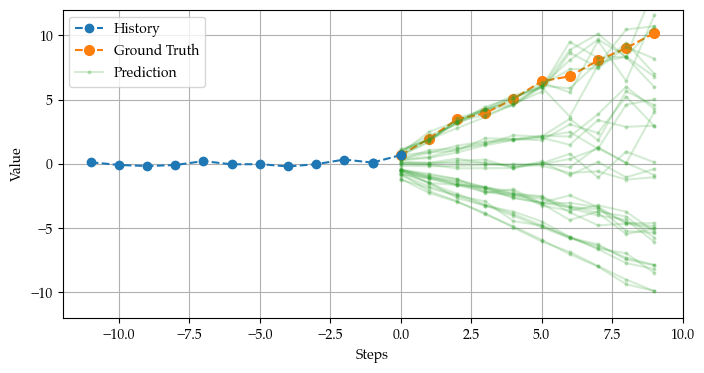

In [1077]:
index = 5 # choose an index you want to plot
hw1_helper.plot_data_generative(history=history, future=future, prediction=prediction, index=index, xlims=xlims, ylims=ylims)
